### Helper Functions

In [153]:
import numpy as np
import re
# %matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import ipywidgets as widgets
from IPython.display import display
from itertools import cycle
import warnings

#### BLG & RSI

In [4]:
def blg(mid_prices, window_size = 20):
    cum_sum = np.cumsum(mid_prices)
    window_sum = cum_sum[window_size:] - cum_sum[:-window_size]
    window_avg = window_sum / window_size
    cum_sum_sq = np.cumsum(np.square(mid_prices))
    window_sum_sq = cum_sum_sq[window_size:] - cum_sum_sq[:-window_size]
    window_avg_sq = window_sum_sq / window_size

    window_variance = window_avg_sq - np.square(window_avg)
    window_std = np.sqrt(window_variance)
    return np.concatenate((np.full(window_size,np.nan),window_avg)), np.concatenate((np.full(window_size,np.nan),window_std))

In [5]:
def rsi_calc(price_history:pd.DataFrame, n:int=20)->pd.DataFrame:
    """
    Input: 
    price_history -- a pandas DataFrame of mid prices

    Return:
    rsi -- a pandas DataFrame of rsi indices, the first n elements will be NAN 
    """
    change = price_history.diff()
    # Create two copies of the Closing price Series
    change_up = change.copy()
    change_down = change.copy()

    # Seperate the upward changes, and download changes
    change_up[change_up<0] = 0
    change_down[change_down>0] = 0

    # Verify that we did not make any mistakes
    change.equals(change_up+change_down)

    # Calculate the rolling average of average up and average down
    avg_up = change_up.rolling(n).mean()
    avg_down = change_down.rolling(n).mean().abs()
    rsi = 100 - 100/(1+ (avg_up/avg_down))
    return rsi

#### Process

In [6]:
import csv
import os

def process_log_file(filename):
    """
    Reads a log file and extracts the contents after "activities log:" into a CSV file with the same name.
    """
    with open(filename, 'r') as f:
        lines = f.readlines()
        print(f"finished reading {filename}")

    # Find the index of the line that says "activities log:"
    activities_index = -1
    for i, line in enumerate(lines):
        if line.startswith("Activities log:"):
            activities_index = i
            break

    # If "activities log:" is not found, return
    if activities_index == -1:
        return

    # Extract the lines after "activities log:"
    activities_lines = lines[activities_index + 1:]

    # Remove any leading or trailing whitespace from each line
    activities_lines = [line.strip() for line in activities_lines]

    csv_filename = f"{filename.split('.log')[0]}.csv"
    
    if os.path.exists(csv_filename):
        print(f"Error: File '{csv_filename}' already exists.")
        return csv_filename

    # Write the contents to a CSV file with the same name as the log file
    with open(csv_filename, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerows([line.split(',') for line in activities_lines])
        print(f"{csv_filename} created and written to.")
        return csv_filename

In [7]:
def get_data(log_file_path, products):
    # from csv in the log
    csv_path = process_log_file(log_file_path)
    with open(log_file_path, "r") as f:
        log_file = f.read()

    product_dfs = []
    position_list = []
    mid_prices_list = []
    best_bid_prices_list = []
    best_ask_prices_list = []
    for product in products:
        df = pd.read_csv(csv_path, delimiter=";")
        product_df = df.loc[df["product"]==product]
        product_dfs.append(product_df)
        mid_prices = np.array(product_df["mid_price"])
        best_bid_prices = np.array(product_df["bid_price_1"])
        best_ask_prices = np.array(product_df["ask_price_1"])
        mid_prices_list.append(mid_prices)
        best_bid_prices_list.append(best_bid_prices)
        best_ask_prices_list.append(best_ask_prices)

        # directly from log
        log_profits = re.findall(r"if it is last round, profit = (-?\d+(?:\.\d+)?)", log_file)
        positions = re.findall(rf"{product}'s position = (-?\d+)", log_file)
#         positions = [0] * (len(mid_prices)-len(positions)) + positions
        positions = [float(num) for num in positions]
        position_list.append(positions)
        # buy_profit_margin = re.findall(r"buy profit margin is (-?\d+)", log_file)
        # buy_profit_margin = [float(x) for x in buy_profit_margin]
        # sell_profit_margin = re.findall(r"sell profit margin is (-?\d+)", log_file)
        # sell_profit_margin = [float(x) for x in sell_profit_margin]

    return product_dfs, mid_prices_list, position_list, best_bid_prices_list, best_ask_prices_list

#### Plot

In [8]:
def plot(mid_prices_list, window_size, n, bound, starting, end, log_file_path, 
         product_dfs, position_list, position_limits,
         best_bid_list, best_ask_list):
    start = starting
    if (start >= end):
        return
    fig, axes = plt.subplots(3,1,figsize=(20, 12),sharex=True)
    fig.suptitle(f"{log_file_path.split('/')[-1]}")
    fig.set_tight_layout(True)
    fig.set_facecolor('white')
    
    profits=[]
    for product_df,positions,mid_prices,position_limit\
          in zip(product_dfs,position_list,mid_prices_list,position_limits):
        x = np.array(range(start,end))
        y = mid_prices[start:end]
        product = product_df["product"].iloc[0]

        rsi = rsi_calc(pd.Series(mid_prices))

        # avg_avg, _ = blg(avg, window_size)
        # avg_avg = np.concatenate((avg[:start], avg_avg))
        # dy = np.gradient(avg_avg)

        # Find the indices where the sign of the derivative changes
        # indices = np.where(np.diff(np.sign(dy)))[0]

        # blg
        avg, std = blg(mid_prices[start:end], window_size)
        upper = avg + n * std + bound
        lower = avg - n * std - bound

        axes[0].plot(x, y, label=product, marker='o', markersize=1)
        axes[0].set_ylabel("Mid price")
        if n > 0 and window_size > 0:
            axes[0].plot(x, avg)
            # axes[0].plot(x, avg_avg[:length], label="moving average's average")
            axes[0].fill_between(x, upper, lower, alpha=0.1)
            # axes[0].fill_between(x, (avg_avg + n * std)[:length], (avg_avg - n * std)[:length], alpha=0.1)
            # axes[0].scatter(x[indices],avg[indices], marker='o',color='blue', s=8000/length,zorder=2)
            axes[0].scatter(x[y>upper],y[y>upper], marker='o',color='red', s=8000/end,zorder=2)
            axes[0].scatter(x[y<lower],y[y<lower], marker='o',color='red', s=8000/end,zorder=2)


        profits.append(product_df["profit_and_loss"][start:end])
        axes[1].plot(x, product_df["profit_and_loss"][start:end], label=product, alpha=0.6)
        axes[1].set_ylabel("Profit")

        axes[2].plot(x, positions[start:end], label=product)
        axes[2].set_ylabel("Position")
        axes[2].set_ybound(-position_limit,position_limit)
        axes[2].legend(loc='upper left')

    axes[1].plot(np.sum(profits,axis=0),label="profit sum", linewidth=4)
    
    axes[0].legend(loc='upper left')
    axes[1].legend(loc='upper left')


    # axes[3].plot(x, rsi[window_size:length], label="rsi")
    # if buy_profit_margin != [] and sell_profit_margin != []:
    #     axes[3].plot(x,buy_profit_margin[window_size:length],label="buy profit margin")
    #     axes[3].plot(x,sell_profit_margin[window_size:length],label="sell profit margin")

    for ax in axes:
        ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
        ax.set_xticks(np.arange(starting,end, max(1,(end-start)//40)))

    plt.subplots_adjust(hspace=0)
    plt.show()

In [9]:
def plot_ruige(mid_prices_list, window_size, n, bound, starting, end, log_file_path, 
         product_dfs, position_list, position_limits,
         best_bid_list, best_ask_list):
    """
    just for round 4's 4 new products
    """
    start = starting
    if (start >= end):
        return
    fig, axes = plt.subplots(4,1,figsize=(20, 12),sharex=True)
    fig.suptitle(f"{log_file_path.split('/')[-1]}")
    fig.set_tight_layout(True)
    fig.set_facecolor('white')
    
    x = np.array(range(start,end))
    
    products = [product_df["product"].iloc[0] for product_df in product_dfs]
    profits=[]
    for product_df,positions,mid_prices,position_limit\
          in zip(product_dfs,position_list,mid_prices_list,position_limits):
        y = mid_prices[start:end]
        product = product_df["product"].iloc[0]
        
        # blg
        avg, std = blg(mid_prices[start:end], window_size)
        upper = avg + n * std + bound
        lower = avg - n * std - bound
        
        if n > 0 and window_size > 0:
            pass
#             axes[0].plot(x, avg)
#             axes[0].fill_between(x, upper, lower, alpha=0.1)
#             axes[0].scatter(x[y>upper],y[y>upper], marker='o',color='red', s=8000/end,zorder=2)
#             axes[0].scatter(x[y<lower],y[y<lower], marker='o',color='red', s=8000/end,zorder=2)

        # profit
        profits.append(product_df["profit_and_loss"][start:end])
        axes[1].plot(x, product_df["profit_and_loss"][start:end], label=product, alpha=0.6)
        axes[1].set_ylabel("Profit")
        
        # position
        axes[3].plot(x, positions[start:end], label=product)
        axes[3].set_ylabel("Position")
        axes[3].set_ybound(-position_limit,position_limit)
        axes[3].legend(loc='upper left')

    # mid prices
    axes[0].plot(x, mid_prices_list[-1], label=products[-1], marker='o', markersize=1)
    axes[0].plot(x, np.sum(mid_prices_list[0:-1],axis=0), label=("-".join(products[0:-1])), marker='o', markersize=1)
    axes[0].set_ylabel("Mid price")
        
    # profit sum
    axes[1].plot(x,np.sum(profits,axis=0)[start:end],label="profit sum", linewidth=4)
    
    # price diff
    price_diff = mid_prices_list[-1] - np.sum(mid_prices_list[0:-1],axis=0)
    axes[2].plot(x,price_diff[start:end],label="price diff")
    axes[2].set_ylabel("Price Difference")

    
    axes[0].legend(loc='upper left')
    axes[1].legend(loc='upper left')
    axes[2].legend(loc='upper left')

    for ax in axes:
        ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
        ax.set_xticks(np.arange(starting,end, max(1,(end-start)//40)))

    plt.subplots_adjust(hspace=0)
    plt.show()

#### Plot From CSVs

In [10]:
# log_name = """
# ruige
# """

def gui(products, position_limits, normalization_multipliers,log_name):
    def update_plot(window_size,starting,end,n):
#         if log_file == ():
#             print("Upload a log file first.")
#             return
        
#         log_name = log_file[0].name
        log_file_path = f"logs/{log_name.strip()}.log"

        
        product_dfs, mid_prices_list, positions, best_bid_list, best_ask_list = get_data(
            log_file_path, products)
        
        normalized_mid_prices = [mid_prices*mult for mid_prices,mult in zip(mid_prices_list, normalization_multipliers)]
        
        plot_ruige(
            normalized_mid_prices, 
            window_size=int(window_size), n=n, bound=1, starting=int(starting), end=int(end),
            log_file_path=log_file_path, product_dfs=product_dfs, position_list=positions,
            position_limits=position_limits, best_bid_list=best_bid_list, best_ask_list=best_ask_list)


#     uploader = widgets.FileUpload(accept='.log', multiple=False)

    window_slider = widgets.FloatSlider(min=0, max=100, step=1, value=10)
    n_slider = widgets.FloatSlider(min=0, max=10, step=0.1, value=1.5)
    starting_slider = widgets.FloatSlider(min=0, max=1000, step=1, value=0)
    end_slider = widgets.FloatSlider(min=0, max=1000, step=1, value=1000)
    widgets.interact(update_plot,
                     window_size=window_slider,
                     starting=starting_slider,
                     end=end_slider,
                     n=n_slider,
#                      log_file=uploader
                     )


### Round 5 Hanson

今天新给的信息是我们知道不同的trading bots的编号 所以可以map出来bots在5个trading periods的behaviours。目前的working theory是有一些bots有additional information会低买高卖，有一些bots 就是在randomly的做trade。为了identify哪些bots有information，需要的工具是plot出某个商品的mid-price line以及trade这个商品的bots的进场时间和出场时间。Ideally就是一张mid-price图，可以换商品和换天数，然后每个bot由不同的颜色代表，进场和出场也不同颜色。现在可以先不管他们每次买入卖出的quantity，完全只看direction。

timestamp;buyer;seller;symbol;currency;price;quantity

In [159]:
def update_round5_plot(bots, products, rnd, day, start, end):
    if rnd == 1:
        day -= 3
    elif rnd == 2:
        day -= 2
    elif rnd == 3:
        day -= 1
    data_path = f"island-data-bottle-round-5/trades_round_{rnd}_day_{day}_wn.csv"
    df1 = pd.read_csv(data_path, delimiter=';')
    price_data_path = f"past-prices-data/prices_round_{rnd}_day_{day}.csv"
    df2 = pd.read_csv(price_data_path, delimiter=';')

    # init fig
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
    fig.suptitle(f"{data_path.split('/')[-1]}")
    fig.set_tight_layout(True)
    fig.set_facecolor('white')
    colors = cycle(plt.cm.Dark2(np.linspace(0, 1, 8)))

    for product in products:
        product_df = df1.loc[df1["symbol"] == product].loc[df1['timestamp']
                                                           >= start*100].loc[df1["timestamp"] <= end*100]
        # print(product_df)
        price_df = df2.loc[df2["product"] == product].loc[df2['timestamp']
                                                          >= start*100].loc[df2["timestamp"] <= end*100]
        # print(price_df)

        # print mid price
        x = price_df["timestamp"] / 100
        mid_price = price_df["mid_price"]
        ax1.plot(x, mid_price, label=product)

        for bot in bots:
            buy_df = product_df.loc[product_df["buyer"] == bot]
            sell_df = product_df.loc[product_df["seller"] == bot]
            buy_color = next(colors)
            sell_color = next(colors)
            for index, row in buy_df.iterrows():
                ax2.plot([row["timestamp"]/100, row["timestamp"]/100],
                         [0, row["quantity"]], c=buy_color)
            for index, row in sell_df.iterrows():
                ax2.plot([row["timestamp"]/100, row["timestamp"]/100],
                         [0, -row["quantity"]], c=sell_color)
            # ax2.bar(buy_df["timestamp"]/100, buy_df["quantity"], label=bot+"_sell",bottom=0)
            # ax2.bar(sell_df["timestamp"]/100, -sell_df["quantity"], label=bot+"_buy",bottom=0)
            ax2.scatter(buy_df["timestamp"]/100,
                        buy_df["quantity"], label=bot+"_buy", c=[buy_color]*len(buy_df))
            ax2.scatter(sell_df["timestamp"]/100, -
                        sell_df["quantity"], label=bot+"_sell", c=[sell_color] * len(sell_df))
            pass

    for ax in (ax1, ax2):
        ax.legend(loc='upper left')
        ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
        ax.set_xticks(np.arange(start, end, max(1, (end-start)//40)))


def round_5_gui():
    label = widgets.Label('Hold ctrl or shift to select multiple products:')
    display(label)
    product_select = widgets.SelectMultiple(
        options=["BANANAS", "PEARLS", "BERRIES", "DIVING_GEAR",
                 "DOLPHIN_SIGHTINGS", "COCONUTS", "PINA_COLADAS"], value=["BANANAS"])
    bots_select = widgets.SelectMultiple(
        options=sorted(["Peter", "Pablo", "Mitch", "Gary", "Penelope",
                        "Omar", "Camilla", "Caesar", "Giulia", "Mabel",
                        "Charlie", "Olivia", "Orson", "Casey", "George",
                        "Mya", "Max", "Paris", "Gina", "Olga"]), value=["Pablo"])
    day_dropdown = widgets.Dropdown(options=[1, 2, 3], value=1)
    round_dropdown = widgets.Dropdown(options=[1, 2, 3, 4], value=1)
    starting_slider = widgets.IntSlider(min=0, max=10000, step=1, value=0)
    end_slider = widgets.IntSlider(min=0, max=10000, step=1, value=10000)
    select_box = widgets.HBox([product_select, bots_select])
    widget= widgets.interactive(update_round5_plot,bots=bots_select, products=product_select, rnd=round_dropdown, day=day_dropdown, start=starting_slider, end=end_slider)
    controls = widgets.HBox(widget.children[:-1], layout = widgets.Layout(flex_flow='row wrap'))
    output = widget.children[-1]
    display(widgets.VBox([controls, output]))

# widgets.interact(update_round5_plot,
#                  bots=bots_select,
#                  products=product_select,
#                  rnd=round_dropdown,
#                  day=day_dropdown,
#                  start=(starting_slider),
#                  end=(end_slider),
#                  )


👇 RUN ME TO GET GRAPH 👇

Label(value='Hold ctrl or shift to select multiple products:')

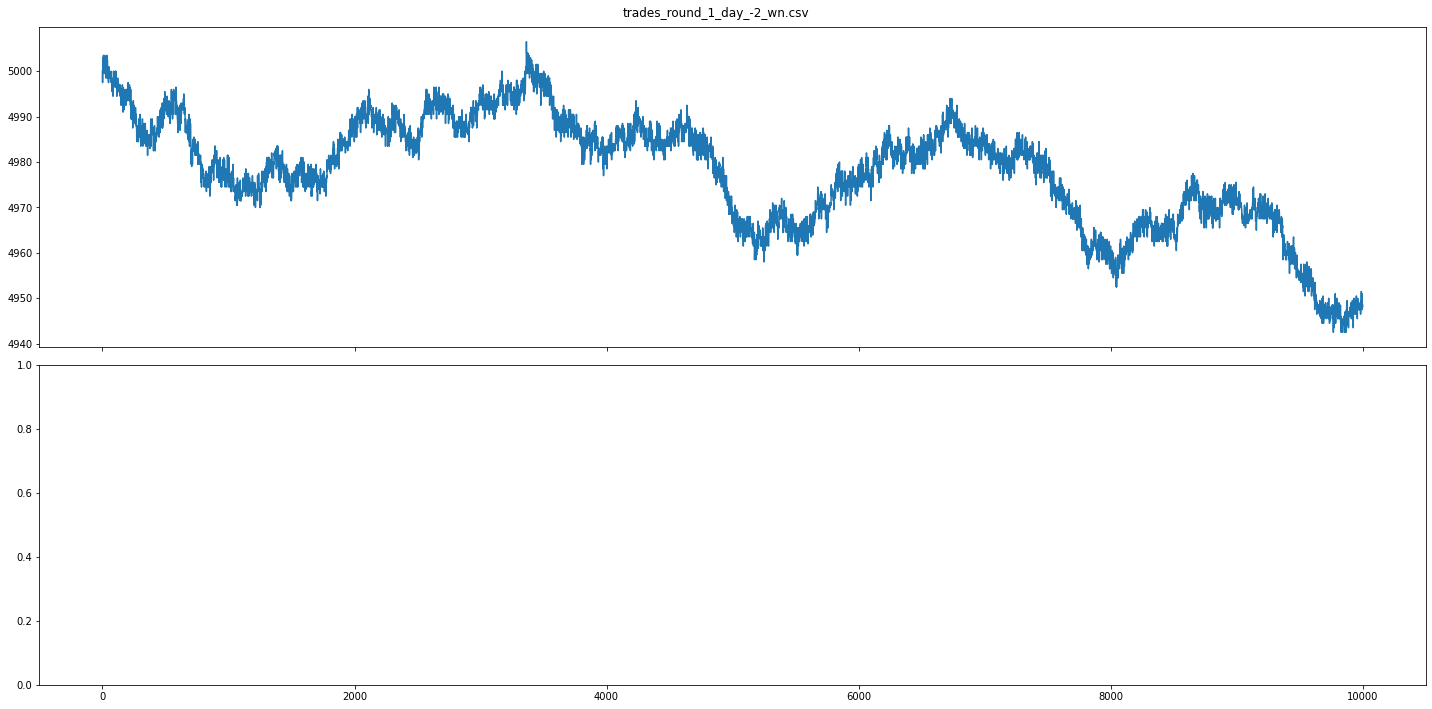

In [160]:
round_5_gui()

### PICNIC_BASKET and Others

👇 RUN ME TO GET GRAPH 👇

1. Graph 1: plot the mid price of the main product (PICNIC_BASKET) and the mid price of the SUM of the components ('BAGUETTE', 'DIP', 'UKULELE', weighted) as a function of time
2. Graph 2: plot the difference between the mid price of the main product and the mid price of the SUM of the components (weighted) as a function of time
3. Graph 3: plot the profit of the main product and the profit of the SUM of the components (weighted) as a function of time
4. Graph 4: plot the position of the main product and that of the normalized (w.r.t. main product) components (a bit difficult to do)

In [ ]:
products = [
# "PINA_COLADAS",
# "COCONUTS",
# "PEARLS",
# "BANANAS",
'BAGUETTE',
'DIP',
'UKULELE',
'PICNIC_BASKET'
]
position_limits = [
    # 300,
    # 600,
    # 20,
    # 20
    150,
    300,
    70,
    70
]

normalization_multipliers = [
    # 8,
    # 15,
    # 1,
    # 1,
    2,
    4,
    1,
    1,
]

gui(products, position_limits, normalization_multipliers,
    log_name = "round4_mixed_difference_moving_average_mean_reversion"
)

interactive(children=(FloatSlider(value=10.0, description='window_size', step=1.0), FloatSlider(value=0.0, des…

### Berries Profit Estimation

In [ ]:
def update_profit_plot(products, day, start, end, window_size, n, plateau_starts, upward_starts, down_starts, down_ends):
    if (len(products) == 0):
        return
    if start >= end:
        return
    # day = 0 # 0, 1 or 2
    csv_path = f"data/island-data-bottle-round-3/prices_round_3_day_{day}.csv"
    df = pd.read_csv(csv_path, delimiter=';')

    fig, axes = plt.subplots(len(products)+1, 1, figsize=(20, 12), sharex=True)
    fig.suptitle(f"{products} day {day}")
    fig.set_tight_layout(True)
    fig.set_facecolor('white')

    for i, product in enumerate(products):
        product_df = df.loc[df["product"] == product]

        x = np.array(range(start, end))
        y = product_df["mid_price"][start:end]

        axes[i].set_ylim(bottom=np.min(y), top=np.max(y))

        axes[i].plot(x, y, label="mid price")
        # axes[0].plot(x, berries_df["bid_price_1"][start:end],
        #              label="best bid", linewidth=.4, alpha=0.5)
        # axes[0].plot(x, berries_df["ask_price_1"][start:end],
        #              label="best ask", linewidth=.4, alpha=0.5)
        axes[i].fill_between(x, y, where=(x >= plateau_starts) & (
            x <= upward_starts), alpha=0.15)
        axes[i].fill_between(x, y, where=(x >= upward_starts) & (
            x <= down_starts), alpha=0.15)
        axes[i].fill_between(x, y, where=(x >= down_starts) & (
            x <= down_ends), alpha=0.15)

        # blg
        avg, std = blg(
            np.array(product_df["mid_price"][start:end]), window_size)
        upper = avg + n * std
        lower = avg - n * std
        if n > 0 and window_size > 0:
            axes[i].plot(x, avg, label="moving avg")
            axes[i].fill_between(x, upper, lower, alpha=0.3)
            axes[i].scatter(x[y > upper], y[y > upper], marker='o',
                            color='red', s=20000/(end-start), zorder=2)
            axes[i].scatter(x[y < lower], y[y < lower], marker='o',
                            color='red', s=20000/(end-start), zorder=2)

        axes[i].legend(loc='upper left')
        axes[i].set_title(f"{product}")

    for ax in axes:
        ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
        ax.set_xticks(np.arange(start, end, max(100, (end-start)//40)))
    plt.xticks(rotation=45)


def profit_gui():
    label = widgets.Label('Hold ctrl or shift to select multiple products:')
    display(label)
    product_select = widgets.SelectMultiple(options=["BERRIES", "DIVING_GEAR", "DOLPHIN_SIGHTINGS","COCONUTS","PINA_COLADAS"],
                                            value=["DIVING_GEAR",
                                                   "DOLPHIN_SIGHTINGS"])
    day_dropdown = widgets.Dropdown(options=[0, 1, 2], value=0)
    starting_slider = widgets.IntSlider(min=0, max=10000, step=1, value=0)
    end_slider = widgets.IntSlider(min=0, max=10000, step=1, value=10000)
    window_slider = widgets.IntSlider(min=0, max=1000, step=1, value=100)
    n_slider = widgets.FloatSlider(min=0, max=10, step=0.1, value=2)
    plateau_starts = widgets.IntSlider(min=0, max=10000, step=1, value=2000)
    upward_starts = widgets.IntSlider(min=0, max=10000, step=1, value=4000)
    down_starts = widgets.IntSlider(min=0, max=10000, step=1, value=5500)
    down_ends = widgets.IntSlider(min=0, max=10000, step=1, value=7000)
    widgets.interact(update_profit_plot,
                     products=product_select,
                     day=day_dropdown,
                     start=(starting_slider),
                     end=(end_slider),
                     window_size=window_slider,
                     n=n_slider,
                     plateau_starts=plateau_starts,
                     upward_starts=upward_starts,
                     down_starts=down_starts,
                     down_ends=down_ends,
                     )


👇 RUN ME TO GET GRAPH 👇

In [ ]:
profit_gui()

FileNotFoundError: [Errno 2] No such file or directory: 'data/island-data-bottle-round-3/prices_round_3_day_0.csv'

interactive(children=(SelectMultiple(description='products', index=(1, 2), options=('BERRIES', 'DIVING_GEAR', …

There will be no significant price trend between 2000-4000(5:00-10:00). Significant upward trend takes place between 4000-5500 (10:00-12:00), followed by a downward trend between 5500-7000(12:00-16:00). After 7000(16:00), price exhibits no predictable trend.

---

### Arbitrage

In [ ]:
def update_arbitrage_plot(day, start, end, window_smaller, window_larger, n):
    if start >= end:
        return
    # day = 0 # 0, 1 or 2
    csv_path = f"data/island-data-bottle-round-3/prices_round_3_day_{day}.csv"
    # csv_path = f"logs/price-diff-larger=45-smaller=35.csv"
    df = pd.read_csv(csv_path, delimiter=';')

    fig, axes = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
    fig.suptitle(f"arbitrage day {day}")
    fig.set_tight_layout(True)
    fig.set_facecolor('white')

    coco_df = df.loc[df["product"] == "COCONUTS"]

    pina_df = df.loc[df["product"] == "PINA_COLADAS"]
    coco_subset = coco_df["mid_price"][start:end]

    pina_subset = pina_df["mid_price"][start:end]

    x = np.array(range(start, end))
    y = np.array(coco_df["mid_price"][start:end] * 15) - np.array(pina_df["mid_price"][start:end] * 8)
    y_sum = np.array(coco_df["mid_price"][start:end] * 15) + np.array(pina_df["mid_price"][start:end] * 8)
    

    axes[0].set_ylim(bottom=np.min(y), top=np.max(y))

    axes[0].plot(x, y, label="mid price difference")
    axes[1].plot(x, coco_subset * 15, label="coconuts")
    axes[1].plot(x, pina_subset * 8, label="pina coladas")
    # axes[1].plot(x, y_sum, label="pina coladas")
    # axes[0].plot(x, berries_df["bid_price_1"][start:end],
    #              label="best bid", linewidth=.4, alpha=0.5)
    # axes[0].plot(x, berries_df["ask_price_1"][start:end],
    #              label="best ask", linewidth=.4, alpha=0.5)

    # blg
    avg, std = blg(np.array(y), window_smaller)
    avg_larger, _ = blg(np.array(y), window_larger)
    diff = avg - avg_larger
    idx = np.argwhere(np.diff(np.sign(diff))).flatten()

    dydx = np.gradient(avg, x)
    d2ydx2 = np.gradient(dydx, x)

    # Find the locations of the turning points
    turning_indices = np.where(np.diff(np.sign(dydx)))[0] + 1

    upper = avg + n * std
    lower = avg - n * std
    if n > 0 and window_smaller > 0 and window_larger > 0:
        axes[0].plot(x, avg, label="moving avg")
        axes[0].plot(x, avg_larger, label="moving avg", zorder=10)
        axes[0].fill_between(x, upper, lower, alpha=0.3)
        axes[0].scatter(x[y > upper], y[y > upper], marker='o',
                        color='red', s=50000/(end-start), zorder=2)
        axes[0].scatter(x[y < lower], y[y < lower], marker='o',
                        color='red', s=50000/(end-start), zorder=2)
        axes[0].scatter(x[idx], avg[idx], marker='o',
                        color='blue', s=50000/(end-start), zorder=2)
        # axes[0].scatter(x[turning_indices], avg[turning_indices], marker='o',
        #                 color='blue', s=50000/(end-start), zorder=2)

    axes[0].legend(loc='upper left')
    axes[1].legend(loc='upper left')

    for ax in axes:
        ax.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.5)
        ax.set_xticks(np.arange(start, end, max(100, (end-start)//40)))
    plt.xticks(rotation=45)


def arbitrage_gui():
    product_select = widgets.SelectMultiple(options=["BERRIES", "DIVING_GEAR", "DOLPHIN_SIGHTINGS","COCONUTS","PINA_COLADAS"],
                                            value=["DIVING_GEAR",
                                                   "DOLPHIN_SIGHTINGS"])
    day_dropdown = widgets.Dropdown(options=[0, 1, 2], value=0)
    starting_slider = widgets.IntSlider(min=0, max=10000, step=1, value=0)
    end_slider = widgets.IntSlider(min=0, max=10000, step=1, value=1000)
    window_slider = widgets.IntSlider(min=0, max=1000, step=1, value=35)
    window_slider2 = widgets.IntSlider(min=0, max=1000, step=1, value=45)
    n_slider = widgets.FloatSlider(min=0, max=10, step=0.1, value=4)
    plateau_starts = widgets.IntSlider(min=0, max=10000, step=1, value=2000)
    upward_starts = widgets.IntSlider(min=0, max=10000, step=1, value=4000)
    down_starts = widgets.IntSlider(min=0, max=10000, step=1, value=5500)
    down_ends = widgets.IntSlider(min=0, max=10000, step=1, value=7000)
    widgets.interact(update_arbitrage_plot,
                     day=day_dropdown,
                     start=(starting_slider),
                     end=(end_slider),
                     window_smaller=window_slider,
                     window_larger=window_slider2,
                     n=n_slider,
                     )


👇 RUN ME TO GET GRAPH 👇

In [ ]:
arbitrage_gui()

FileNotFoundError: [Errno 2] No such file or directory: 'data/island-data-bottle-round-3/prices_round_3_day_0.csv'

interactive(children=(Dropdown(description='day', options=(0, 1, 2), value=0), IntSlider(value=0, description=…